<a href="https://colab.research.google.com/github/kla55/Pytorch_learning/blob/main/projects/simple_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim

In [1]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

NameError: ignored

In [2]:
train_data = datasets.Food101(
    root="data",
    split='train',
    download=True,
    transform=ToTensor()
)

test_data = datasets.Food101(
    root="data",
    split='test',
    download=True,
    transform=ToTensor())

NameError: ignored

In [36]:
train_data = datasets.MNIST(root=".",
                            train=True,
                            download=True,
                            transform=ToTensor())

test_data = datasets.MNIST(root=".",
                           train=False,
                           download=True,
                           transform=ToTensor())


48124
52149
8029
16284
22441


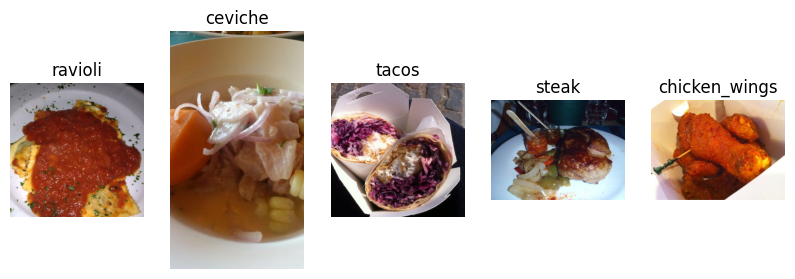

In [44]:

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,15))
rows, cols = 1, 5
for i in range(1, 6):
  random_inx = torch.randint(0,len(train_data), size =[1]).item()
  print(random_inx)
  image, label = train_data[random_inx]
  image = np.transpose(image, (1, 2, 0))
  fig.add_subplot(rows, cols, i)
  plt.imshow(image.squeeze(), cmap = 'gray')
  plt.title(train_data.classes[label])
  plt.axis(False)


In [45]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78e05135e9e0>, <torch.utils.data.dataloader.DataLoader object at 0x78e05135f400>)
Length of train dataloader: 2368 batches of 32
Length of test dataloader: 790 batches of 32


In [65]:
train_features, train_labels = next(iter(train_data))

In [66]:
train_features.shape

torch.Size([3, 512, 512])

In [78]:
from torch import nn

class model_v0(torch.nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
                    nn.Conv2d(in_channels=input_shape,
                              out_channels=hidden_units,
                              kernel_size=3,
                              stride=1,
                              padding=1),
                    nn.ReLU(),
                    nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units,
                        kernel_size=3,
                        stride=1,
                        padding=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2))

    self.conv_block_2 = nn.Sequential(
                      nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                      nn.ReLU(),
                      nn.Conv2d(in_channels=hidden_units,
                                out_channels=hidden_units,
                                kernel_size=3,
                                stride=1,
                                padding=1),
                      nn.ReLU(),
                      nn.MaxPool2d(kernel_size=2))

    self.classifier = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(in_features=hidden_units*7*7,
                              out_features=output_shape))

  def forward(self, x):
                    x = self.conv_block_1(x)
                    # print(f"Output shape of conv block 1: {x.shape}")
                    x = self.conv_block_2(x)
                    # print(f"Output shape of conv block 2: {x.shape}")
                    x = self.classifier(x)
                    # print(f"Output shape of classifier: {x.shape}")
                    return x

In [79]:
model_V0 = model_v0(input_shape=1,
                  hidden_units=10,
                  output_shape=10).to(device)
model_V0



NameError: ignored

In [48]:
data = train_dataloader.dataset.data
shape = train_dataloader.dataset.data.shape
datatype = train_dataloader.dataset.data.dtype

AttributeError: ignored

In [ ]:
temp = image.reshape(3,500,500)

In [ ]:
image.shape

In [ ]:
image.shape

In [ ]:
training_data

In [ ]:
projects/simple_nn.ipynb